In [1]:
## No elimine esta celda, ya que permite actualizar los archivos .py
## sin tener que reiniciar el Kernel de Jupyter.
%load_ext autoreload
%autoreload 2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.datasets import ImageFolder
import numpy as np
import torch
import timm
from train import automate_training
from transforms import Transforms
from utils import plot_images, set_seed, count_instances_per_class
import os
from torch.utils.data import random_split
import warnings
import json

warnings.filterwarnings("ignore", message = "Palette images with Transparency expressed in bytes should be converted to RGBA images")
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

set_seed()


In [2]:
train_transforms = A.Compose(
    [A.Resize(256, 256), A.ToFloat(), ToTensorV2()]
)
validation_transforms = A.Compose(
    [A.Resize(256, 256), A.ToFloat(), ToTensorV2()]
)


train_data = ImageFolder(
    "house_plant_species/train",
    transform = Transforms(train_transforms),
)
validation_data = ImageFolder(
    "house_plant_species/validation",
    transform = Transforms(validation_transforms),
)

## We get the test data
test_size = int(0.2 * len(validation_data))
validation_size = len(validation_data) - test_size

# Dividir el conjunto de validación en validación (80%) y prueba (20%)
validation_data, test_data = random_split(validation_data, [validation_size, test_size])

print(f"Elementos en Entrenamiento: {len(train_data)}")
print(f"Elementos en Validación: {len(validation_data)}")
print(f"Elementos en Prueba: {len(test_data)}")
print(f"There are {len(train_data.classes)} classes!")
# train_data.classes

# Llamar a las funciones
class_counts = count_instances_per_class(train_data)

# Calcular estadísticas
class_instance_counts = np.array(list(class_counts.values()))
mean_instances = np.mean(class_instance_counts)
std_instances = np.std(class_instance_counts)
min_instances = np.min(class_instance_counts)
max_instances = np.max(class_instance_counts)

# # Mostrar resultados
# print("\nInstancias por clase:\n")
# for class_name, count in class_counts.items():
#     print(f"Clase {class_name}: {count} imágenes\n===========================================")

print("\nEstadísticas de las instancias por clase:\n")
print(f"Promedio de instancias:\n============================== {mean_instances:.2f}")
print(f"Desviación estándar:\n============================== {std_instances:.2f}")
print(f"Cantidad mínima de instancias:\n============================== {min_instances}")
print(f"Cantidad máxima de instancias:\n============================== {max_instances}")

Elementos en Entrenamiento: 10835
Elementos en Validación: 2189
Elementos en Prueba: 547
There are 47 classes!

Estadísticas de las instancias por clase:

Promedio de instancias:
============================== 230.53
Desviación estándar:
============================== 77.46
Cantidad mínima de instancias:
============================== 49
Cantidad máxima de instancias:
============================== 432


torch.Size([3, 256, 256])


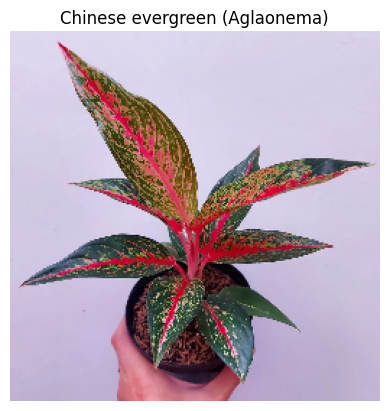

In [3]:
idx = np.random.randint(0, len(train_data))

plot_images(idx, train_data)

# Training with Data Augmentation

In [4]:
efficientnet_models = [
    "efficientnet_b0.ra4_e3600_r224_in1k",
    "efficientnet_b0.ra_in1k",
    "efficientnet_b1.ft_in1k",
    "efficientnet_b1.ra4_e3600_r240_in1k",
    "efficientnet_b1_pruned.in1k",
    "efficientnet_b2.ra_in1k",
    "efficientnet_b2_pruned.in1k",
    "efficientnet_b3.ra2_in1k",
    "efficientnet_b3_pruned.in1k",
    "efficientnet_b4.ra2_in1k",
    "efficientnet_b5.sw_in12k",
    "efficientnet_b5.sw_in12k_ft_in1k",
    "efficientnet_el.ra_in1k",
    "efficientnet_el_pruned.in1k",
    "efficientnet_em.ra2_in1k",
    "efficientnet_es.ra_in1k",
    "efficientnet_es_pruned.in1k",
    "efficientnet_lite0.ra_in1k",
    "efficientnetv2_rw_m.agc_in1k",
    "efficientnetv2_rw_s.ra2_in1k",
    "efficientnetv2_rw_t.ra2_in1k"
]

selected_transforms = ["color_jitter", "horizontal_flip", "brightness_contrast", "blur"]

num_classes = 47

training_params = {
    "learning_rate": 3e-4,
    "batch_size": 32,
    "num_epochs": 50,
}


In [ ]:
automate_training(
    model_names = efficientnet_models,
    selected_transforms = selected_transforms,
    num_classes = num_classes,
    training_params = training_params,
    frozen = True
)

Starting training for model: efficientnet_b0.ra4_e3600_r224_in1k with architecture_name: efficientnet_b0.ra4_e3600_r224_in1k_4_augmented


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Using device: cuda


wandb: Currently logged in as: joseflores1 (benjaminrromo-universidad-adolfo-ib-ez). Use `wandb login --relogin` to force relogin


  2%|▏         | 1/50 [01:12<59:31, 72.89s/it]

Epoch: 1/50 - Time: 72.85s - Train Loss: 2.3069, Train Accuracy: 0.4597 - Validation Loss: 2.3018, Validation Accuracy: 0.6597
Model checkpoint saved at epoch 1


  4%|▍         | 2/50 [02:21<56:17, 70.37s/it]

Epoch: 2/50 - Time: 68.57s - Train Loss: 1.2543, Train Accuracy: 0.6666 - Validation Loss: 1.1205, Validation Accuracy: 0.7113
Model checkpoint saved at epoch 2


  6%|▌         | 3/50 [03:34<55:58, 71.46s/it]

Epoch: 3/50 - Time: 72.72s - Train Loss: 1.0500, Train Accuracy: 0.7087 - Validation Loss: 1.0529, Validation Accuracy: 0.7136
Model checkpoint saved at epoch 3


  8%|▊         | 4/50 [04:49<55:55, 72.94s/it]

Epoch: 4/50 - Time: 75.20s - Train Loss: 0.9483, Train Accuracy: 0.7317 - Validation Loss: 325.5554, Validation Accuracy: 0.7177


 10%|█         | 5/50 [06:01<54:31, 72.70s/it]

Epoch: 5/50 - Time: 72.27s - Train Loss: 0.8858, Train Accuracy: 0.7453 - Validation Loss: 1117.9133, Validation Accuracy: 0.7181


 12%|█▏        | 6/50 [07:08<51:54, 70.78s/it]

Epoch: 6/50 - Time: 67.06s - Train Loss: 0.8278, Train Accuracy: 0.7590 - Validation Loss: 71.7425, Validation Accuracy: 0.7305


 14%|█▍        | 7/50 [08:27<52:32, 73.31s/it]

Epoch: 7/50 - Time: 78.52s - Train Loss: 0.7774, Train Accuracy: 0.7719 - Validation Loss: 289.0789, Validation Accuracy: 0.7232


 16%|█▌        | 8/50 [09:39<51:00, 72.88s/it]

Epoch: 8/50 - Time: 71.92s - Train Loss: 0.7436, Train Accuracy: 0.7833 - Validation Loss: 1.0146, Validation Accuracy: 0.7218
Model checkpoint saved at epoch 8


 18%|█▊        | 9/50 [10:51<49:43, 72.77s/it]

Epoch: 9/50 - Time: 72.55s - Train Loss: 0.7096, Train Accuracy: 0.7919 - Validation Loss: 1.0184, Validation Accuracy: 0.7364


 20%|██        | 10/50 [12:08<49:14, 73.85s/it]

Epoch: 10/50 - Time: 76.27s - Train Loss: 0.6934, Train Accuracy: 0.7945 - Validation Loss: 211.5620, Validation Accuracy: 0.7318


 22%|██▏       | 11/50 [13:22<48:08, 74.06s/it]

Epoch: 11/50 - Time: 74.52s - Train Loss: 0.6459, Train Accuracy: 0.8077 - Validation Loss: 1.0348, Validation Accuracy: 0.7318


 24%|██▍       | 12/50 [14:37<47:00, 74.21s/it]

Epoch: 12/50 - Time: 74.57s - Train Loss: 0.6411, Train Accuracy: 0.8088 - Validation Loss: 658.8281, Validation Accuracy: 0.7200


 26%|██▌       | 13/50 [15:51<45:45, 74.21s/it]

Epoch: 13/50 - Time: 74.20s - Train Loss: 0.6490, Train Accuracy: 0.8094 - Validation Loss: 1831.3580, Validation Accuracy: 0.7250


 28%|██▊       | 14/50 [17:05<44:28, 74.13s/it]

Epoch: 14/50 - Time: 73.94s - Train Loss: 0.6098, Train Accuracy: 0.8174 - Validation Loss: 21.7743, Validation Accuracy: 0.7259


 30%|███       | 15/50 [18:19<43:19, 74.27s/it]

Epoch: 15/50 - Time: 74.58s - Train Loss: 0.5926, Train Accuracy: 0.8246 - Validation Loss: 628.9372, Validation Accuracy: 0.7177


 32%|███▏      | 16/50 [19:33<41:58, 74.08s/it]

Epoch: 16/50 - Time: 73.66s - Train Loss: 0.5892, Train Accuracy: 0.8231 - Validation Loss: 7.7026, Validation Accuracy: 0.7318


 34%|███▍      | 17/50 [20:46<40:38, 73.88s/it]

Epoch: 17/50 - Time: 73.41s - Train Loss: 0.5757, Train Accuracy: 0.8284 - Validation Loss: 1.0277, Validation Accuracy: 0.7332


 34%|███▍      | 17/50 [22:00<42:43, 77.69s/it]

Epoch: 18/50 - Time: 73.78s - Train Loss: 0.5672, Train Accuracy: 0.8295 - Validation Loss: 1.0478, Validation Accuracy: 0.7332
Early stopping triggered at epoch 8. Best Validation Loss: 1.0146


elapsed_time,▅▂▄▆▄▁█▄▄▇▆▆▅▅▆▅▅▅
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_acc,▁▅▆▆▆▇▇▇▇▇████████
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▆▆▆▆▇▇▇███▆▇▇▆███
val_loss,▁▁▁▂▅▁▂▁▁▂▁▄█▁▃▁▁▁
elapsed_time,73.77518
epoch,18
train_acc,0.82951
train_loss,0.56715
val_acc,0.73321



=== Evaluación en el conjunto de prueba ===
Test Accuracy: 0.73492
Resultados guardados correctamente en efficient_net.json
Experimento terminado para efficientnet_b0.ra4_e3600_r224_in1k_4_augmented
Finished training for model: efficientnet_b0.ra4_e3600_r224_in1k

Starting training for model: efficientnet_b0.ra_in1k with architecture_name: efficientnet_b0.ra_in1k_4_augmented
Using device: cuda


  2%|▏         | 1/50 [01:14<1:00:29, 74.07s/it]

Epoch: 1/50 - Time: 74.03s - Train Loss: 2.0012, Train Accuracy: 0.5447 - Validation Loss: 1.0389, Validation Accuracy: 0.7433
Model checkpoint saved at epoch 1


  4%|▍         | 2/50 [02:28<59:21, 74.20s/it]  

Epoch: 2/50 - Time: 74.26s - Train Loss: 0.9990, Train Accuracy: 0.7347 - Validation Loss: 0.8143, Validation Accuracy: 0.7684
Model checkpoint saved at epoch 2


  6%|▌         | 3/50 [03:42<58:15, 74.36s/it]

Epoch: 3/50 - Time: 74.52s - Train Loss: 0.8135, Train Accuracy: 0.7699 - Validation Loss: 0.7316, Validation Accuracy: 0.7944
Model checkpoint saved at epoch 3


  8%|▊         | 4/50 [04:57<57:13, 74.64s/it]

Epoch: 4/50 - Time: 75.02s - Train Loss: 0.6927, Train Accuracy: 0.8076 - Validation Loss: 0.6926, Validation Accuracy: 0.8017
Model checkpoint saved at epoch 4


 10%|█         | 5/50 [06:13<56:11, 74.93s/it]

Epoch: 5/50 - Time: 75.41s - Train Loss: 0.6117, Train Accuracy: 0.8263 - Validation Loss: 0.6849, Validation Accuracy: 0.8068
Model checkpoint saved at epoch 5


 12%|█▏        | 6/50 [07:26<54:35, 74.44s/it]

Epoch: 6/50 - Time: 73.48s - Train Loss: 0.5587, Train Accuracy: 0.8390 - Validation Loss: 0.6869, Validation Accuracy: 0.8022


 14%|█▍        | 7/50 [08:40<53:02, 74.01s/it]

Epoch: 7/50 - Time: 73.11s - Train Loss: 0.5117, Train Accuracy: 0.8482 - Validation Loss: 0.6802, Validation Accuracy: 0.8017
Model checkpoint saved at epoch 7


 16%|█▌        | 8/50 [09:54<51:47, 74.00s/it]

Epoch: 8/50 - Time: 73.93s - Train Loss: 0.4919, Train Accuracy: 0.8563 - Validation Loss: 0.6724, Validation Accuracy: 0.8068
Model checkpoint saved at epoch 8


 18%|█▊        | 9/50 [11:07<50:30, 73.90s/it]

Epoch: 9/50 - Time: 73.69s - Train Loss: 0.4478, Train Accuracy: 0.8670 - Validation Loss: 0.6883, Validation Accuracy: 0.7899


 20%|██        | 10/50 [12:20<49:07, 73.69s/it]

Epoch: 10/50 - Time: 73.22s - Train Loss: 0.4207, Train Accuracy: 0.8712 - Validation Loss: 0.6807, Validation Accuracy: 0.8068


 22%|██▏       | 11/50 [13:35<48:01, 73.89s/it]

Epoch: 11/50 - Time: 74.32s - Train Loss: 0.4145, Train Accuracy: 0.8762 - Validation Loss: 0.6768, Validation Accuracy: 0.8045


 24%|██▍       | 12/50 [14:48<46:36, 73.59s/it]

Epoch: 12/50 - Time: 72.90s - Train Loss: 0.3994, Train Accuracy: 0.8834 - Validation Loss: 0.6893, Validation Accuracy: 0.8004


 26%|██▌       | 13/50 [16:01<45:22, 73.59s/it]

Epoch: 13/50 - Time: 73.61s - Train Loss: 0.3792, Train Accuracy: 0.8840 - Validation Loss: 0.6973, Validation Accuracy: 0.8086


 28%|██▊       | 14/50 [17:15<44:08, 73.58s/it]

Epoch: 14/50 - Time: 73.55s - Train Loss: 0.3583, Train Accuracy: 0.8915 - Validation Loss: 0.6915, Validation Accuracy: 0.8113


 30%|███       | 15/50 [18:29<42:57, 73.64s/it]

Epoch: 15/50 - Time: 73.76s - Train Loss: 0.3518, Train Accuracy: 0.8928 - Validation Loss: 0.7094, Validation Accuracy: 0.8054


 32%|███▏      | 16/50 [19:42<41:46, 73.72s/it]

Epoch: 16/50 - Time: 73.92s - Train Loss: 0.3245, Train Accuracy: 0.9013 - Validation Loss: 0.7182, Validation Accuracy: 0.8072


 34%|███▍      | 17/50 [20:57<40:42, 74.01s/it]

Epoch: 17/50 - Time: 74.66s - Train Loss: 0.3307, Train Accuracy: 0.8984 - Validation Loss: 0.7334, Validation Accuracy: 0.8045


 34%|███▍      | 17/50 [22:14<43:11, 78.52s/it]

Epoch: 18/50 - Time: 77.24s - Train Loss: 0.3217, Train Accuracy: 0.8989 - Validation Loss: 0.7267, Validation Accuracy: 0.7958
Early stopping triggered at epoch 8. Best Validation Loss: 0.6724


elapsed_time,▃▃▄▄▅▂▁▃▂▂▃▁▂▂▂▃▄█
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_acc,▁▅▅▆▇▇▇▇▇▇████████
train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▇█▇▇█▆█▇▇██▇█▇▆
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
elapsed_time,77.24028
epoch,18
train_acc,0.89885
train_loss,0.32168
val_acc,0.7958



=== Evaluación en el conjunto de prueba ===
Test Accuracy: 0.81536
Resultados guardados correctamente en efficient_net.json
Experimento terminado para efficientnet_b0.ra_in1k_4_augmented
Finished training for model: efficientnet_b0.ra_in1k

Starting training for model: efficientnet_b1.ft_in1k with architecture_name: efficientnet_b1.ft_in1k_4_augmented
Using device: cuda


  2%|▏         | 1/50 [01:15<1:01:51, 75.74s/it]

Epoch: 1/50 - Time: 75.69s - Train Loss: 1.9620, Train Accuracy: 0.5493 - Validation Loss: 1.1075, Validation Accuracy: 0.7328
Model checkpoint saved at epoch 1


  4%|▍         | 2/50 [02:30<59:56, 74.94s/it]  

Epoch: 2/50 - Time: 74.32s - Train Loss: 1.0114, Train Accuracy: 0.7307 - Validation Loss: 0.8979, Validation Accuracy: 0.7602
Model checkpoint saved at epoch 2


  6%|▌         | 3/50 [03:50<1:00:47, 77.61s/it]

Epoch: 3/50 - Time: 80.75s - Train Loss: 0.8196, Train Accuracy: 0.7702 - Validation Loss: 0.8260, Validation Accuracy: 0.7739
Model checkpoint saved at epoch 3


  8%|▊         | 4/50 [05:06<58:46, 76.66s/it]  

Epoch: 4/50 - Time: 75.16s - Train Loss: 0.6977, Train Accuracy: 0.8064 - Validation Loss: 0.7884, Validation Accuracy: 0.7839
Model checkpoint saved at epoch 4


 10%|█         | 5/50 [06:22<57:17, 76.39s/it]

Epoch: 5/50 - Time: 75.91s - Train Loss: 0.6311, Train Accuracy: 0.8193 - Validation Loss: 0.7960, Validation Accuracy: 0.7734


 12%|█▏        | 6/50 [07:35<55:23, 75.54s/it]

Epoch: 6/50 - Time: 73.83s - Train Loss: 0.5816, Train Accuracy: 0.8315 - Validation Loss: 0.7733, Validation Accuracy: 0.7839
Model checkpoint saved at epoch 6


 14%|█▍        | 7/50 [08:48<53:32, 74.71s/it]

Epoch: 7/50 - Time: 73.01s - Train Loss: 0.5424, Train Accuracy: 0.8435 - Validation Loss: 0.7753, Validation Accuracy: 0.7876


 16%|█▌        | 8/50 [10:01<51:49, 74.04s/it]

Epoch: 8/50 - Time: 72.59s - Train Loss: 0.5106, Train Accuracy: 0.8479 - Validation Loss: 0.8151, Validation Accuracy: 0.7675


 18%|█▊        | 9/50 [11:13<50:11, 73.46s/it]

Epoch: 9/50 - Time: 72.20s - Train Loss: 0.4867, Train Accuracy: 0.8575 - Validation Loss: 0.7929, Validation Accuracy: 0.7876


 20%|██        | 10/50 [12:27<49:06, 73.66s/it]

Epoch: 10/50 - Time: 74.05s - Train Loss: 0.4548, Train Accuracy: 0.8627 - Validation Loss: 0.7689, Validation Accuracy: 0.7880
Model checkpoint saved at epoch 10


 22%|██▏       | 11/50 [13:41<47:48, 73.54s/it]

Epoch: 11/50 - Time: 73.27s - Train Loss: 0.4294, Train Accuracy: 0.8708 - Validation Loss: 0.8139, Validation Accuracy: 0.7812


 24%|██▍       | 12/50 [14:55<46:49, 73.93s/it]

Epoch: 12/50 - Time: 74.82s - Train Loss: 0.4209, Train Accuracy: 0.8708 - Validation Loss: 0.8087, Validation Accuracy: 0.7844


 26%|██▌       | 13/50 [16:09<45:35, 73.94s/it]

Epoch: 13/50 - Time: 73.98s - Train Loss: 0.3943, Train Accuracy: 0.8801 - Validation Loss: 0.8016, Validation Accuracy: 0.7880


 28%|██▊       | 14/50 [17:25<44:37, 74.37s/it]

Epoch: 14/50 - Time: 75.37s - Train Loss: 0.3898, Train Accuracy: 0.8828 - Validation Loss: 0.8133, Validation Accuracy: 0.7821


 30%|███       | 15/50 [18:43<44:01, 75.46s/it]

Epoch: 15/50 - Time: 77.98s - Train Loss: 0.3711, Train Accuracy: 0.8896 - Validation Loss: 0.7877, Validation Accuracy: 0.7967
